# BDD Assignment #1

The goal of this problem set is to replicate and extend the core results of  Jean et al.'s 2016 paper, "Combining satellite imagery and machine learning to predict poverty." This problem set will be challenging and time-consuming, so I suggest you start immediately. Your first step should be to carefully read <a href="https://pdfs.semanticscholar.org/1b3a/c4b4187a3dbc9373869e7774b1dc63f748d2.pdf">the original paper</a>  as well as the <a href="http://science.sciencemag.org/content/sci/suppl/2016/08/19/353.6301.790.DC1/Jean.SM.pdf">supplementary materials</a>.

For this assignment, we will focus on the country of Rwanda. You will need to download three distinct datasets, including DHS data, satellite data from the Google Maps API, as well as nighttime luminosity data. The DHS data requires registration (which can take several days to be approved), and the Google Maps API is rate-limited, so it will necessarily take you several days to download the requisite data, so make sure to **get started on those steps asap**. The deep learning section may also take several hours to compute (or days, if you have a slow computer), so don't save it until the last minute.

## Overview of the problem set

These are the key steps in the problem set:

1. [Download satellite night lights images from NOAA](#step_1)
2. [Download Rwandan DHS and construct cluster-level aggregates](#step_2)
3. [Test whether night lights data can predict wealth, as observed in DHS](#step_3)
4. [Download daytime satellite imagery from Google Maps](#step_4)
5. [Test whether basic features of daytime imagery can predict wealth](#step_5)
6. [*Optional*: Extract features from daytime imagery using deep learning libraries](#step_6)
7. [*Optional*: Replicate final model and results of Jean et al (2016)](#step_7)
8. [Construct a high-resolution map of the predicted wealth of Rwanda](#step_8)
9. [Step back and interpret your results](#step_9)


<a id='step_1'></a>

# 1. Download satellite night lights images from NOAA

- **INPUT**:
 - None
- **OUTPUT**: 
 - `F182010.v4d_web.stable_lights.avg_vis.tif`: Single image file giving nightlights intensity around the world

Go to the [DMSP-OLS website](https://ngdc.noaa.gov/eog/dmsp/downloadV4composites.html) and download the satellite nighttime luminosity data (roughly 400MB). We will use the one from 2010. The archive they provide constains several files. Feel free to explore these files. We will only be using the file F182010.v4d_web.stable_lights.avg_vis.tif.

A code snippet to get you started is below. Plot a map of nightlight luminosity in Rwanda.

<a id='step_2'></a>

# 2. Download Rwandan DHS and construct cluster-level aggregates

- **INPUT**: 
  - `rwanda_clusters_location.csv`: Coordinates of the centroid of each cluster
- **OUTPUT**: 
  - `rwanda_cluster_avg_asset_2010.csv`: Comma-delimited file indicated average wealth of each cluster 

[Demographic and Health Surveys (DHS)](http://dhsprogram.com/What-We-Do/Survey-Types/DHS.cfm) are nationally-representative household surveys that provide data for a wide range of monitoring and impact evaluation indicators in the areas of population, health, and nutrition. For this assignment, you will need to download the [2010 Rwandan DHS data](http://dhsprogram.com/what-we-do/survey/survey-display-364.cfm). **This requires registration, so start early!** Do not forget to request for the GPS dataset. Make sure you understand the structure of the data before starting.

Your immediate goal is to take the raw survey data, covering 12,540 households, and compute the average household wealth for each survey cluster (think of a cluster as a village). Refer to the file `Recode6_DHS_22March2013_DHSG4.pdf` for information on these data.

Save your output as `rwanda_cluster_avg_asset_2010.csv` and check that it matches the file that we have provided. You will use this file as input to the next step in the assignment.

Conduct some basic statistical analysis of these data, for instance to show the wealth distribution of rwanda (e.g., as a histogram). If you have time, create a map showing the spatial distribution of wealth of Rwanda, as calculated from the DHS. Intpret this analysis -- what have you learned about the distribution of wealth in Rwanda?

Hints:
- `Household Recode` contains all the attributes of each household. It provides datasets with different formats. Feel free to explore the data. You can use `RWHR61FL.DAT` file in Flat ASCII data (.dat) format.
- `RWHR61FL.DCF` describes the attributes and the location of each attribute.
- Geographic Datasets: `rwge61fl.zip` contains the location of each cluster in Rwanda. It is in the format of shapefile, which needs QGIS or other GIS softwares to open. For those who are not familiar with GIS tools or who want a shortcut, you can also sue the file `rwanda_clusters_location.csv` provided with the problem set.

For reference, the cluster locations, overlaid on the nightlights data, are shown in the figure below.
<img src="figure/map1.png" alt="Map" style="width: 600px;"/>


*Replace this section with your observations and interpretation*


<a id='step_3'></a>

# 3. Test whether night lights data can predict wealth, as observed in DHS

Now that you have "ground truth" measures of average cluster wealth, your goal is to understand whether the nightlights data can be used to predict wealth. First, merge the DHS and nightlights data, and then fit a model of wealth on nightlights.

## 3.1 Merge nightlights and DHS data at cluster level
- **INPUT**: 
 - `F182010.v4d_web.stable_lights.avg_vis.tif`: Nightlights data, from Step 1
 - `rwanda_cluster_avg_asset_2010.csv`: DHS cluster averages, from Step 2
- **OUTPUT**: Merged datasets
 - `DHS_nightlights.csv`: Merged dataset with 492 rows, and 6 columns (one indicates average cluster wealth, 5 nightlights features)
 - Scatterplot of nightlights vs. DHS wealth

Perform a "spatial join" to compute the average nighttime luminosity for each of the DHS clusters. To do this, you should take the average of the luminosity values for the nightlights locations surrounding the cluster centroid.

Save your output as `DHS_nightlights.csv` and check that it is the same as the file we have provided.

Create a scatterplot showing the relationship between average cluster wealth (y-axis) and average nighttime luminosity (x-axis). Your scatterplot should have one dot for each of the 492 DHS clusters. Report the R^2 of the regression line.

Hints:
 - The resolution of each pixel in the nightlight image is about 1km. Use 10 pixels X 10 pixels to average the luminosity of each cluster.
 - Start by just taking the **Mean** of the luminosity in the 100 pixels and comparing this to cluster average wealth. If you like, you could also compute other luminosity characteristics of each cluster, such as the **Max**, **Min**, **Standard Deviation** of the 100 pixel values, but this step is not required. Note that the file we provide (`DHS_nightlights.csv`) has these added features.
 - To read the raw raster (nightlights) files, we recommend using the GDAL library. Use `conda install gdal` to install the GDAL library. We have provided some helper code for this below.

In [2]:
import pandas as pd

night = pd.read_csv('intermediate_files/DHS_nightlights.csv')

In [47]:
import time
import os
import os.path
import numpy as np
from osgeo import gdal, ogr, osr
from scipy import ndimage
from scipy import misc
#import cStringIO
from io import StringIO
gdal.UseExceptions()
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
import urllib

# Helper function to read a raster file
def read_raster(raster_file):
    """
    Function
    --------
    read_raster

    Given a raster file, get the pixel size, pixel location, and pixel value

    Parameters
    ----------
    raster_file : string
        Path to the raster file

    Returns
    -------
    x_size : float
        Pixel size
    top_left_x_coords : numpy.ndarray  shape: (number of columns,)
        Longitude of the top-left point in each pixel
    top_left_y_coords : numpy.ndarray  shape: (number of rows,)
        Latitude of the top-left point in each pixel
    centroid_x_coords : numpy.ndarray  shape: (number of columns,)
        Longitude of the centroid in each pixel
    centroid_y_coords : numpy.ndarray  shape: (number of rows,)
        Latitude of the centroid in each pixel
    bands_data : numpy.ndarray  shape: (number of rows, number of columns, 1)
        Pixel value
    """
    raster_dataset = gdal.Open(raster_file, gdal.GA_ReadOnly)
    # get project coordination
    proj = raster_dataset.GetProjectionRef()
    bands_data = []
    # Loop through all raster bands
    for b in range(1, raster_dataset.RasterCount + 1):
        band = raster_dataset.GetRasterBand(b)
        bands_data.append(band.ReadAsArray())
        no_data_value = band.GetNoDataValue()
    bands_data = np.dstack(bands_data)
    rows, cols, n_bands = bands_data.shape


    # Get the metadata of the raster
    geo_transform = raster_dataset.GetGeoTransform()
    (upper_left_x, x_size, x_rotation, upper_left_y, y_rotation, y_size) = geo_transform
    
    # Get location of each pixel
    x_size = 1.0 / int(round(1 / float(x_size)))
    y_size = - x_size
    y_index = np.arange(bands_data.shape[0])
    x_index = np.arange(bands_data.shape[1])
    top_left_x_coords = upper_left_x + x_index * x_size
    top_left_y_coords = upper_left_y + y_index * y_size
    # Add half of the cell size to get the centroid of the cell
    centroid_x_coords = top_left_x_coords + (x_size / 2)
    centroid_y_coords = top_left_y_coords + (y_size / 2)

    return (x_size, top_left_x_coords, top_left_y_coords, centroid_x_coords, centroid_y_coords, bands_data)

In [48]:
# Helper function to get the pixel index of the point
def get_cell_idx(lon, lat, top_left_x_coords, top_left_y_coords):
    """
    Function
    --------
    get_cell_idx

    Given a point location and all the pixel locations of the raster file,
    get the column and row index of the point in the raster

    Parameters
    ----------
    lon : float
        Longitude of the point
    lat : float
        Latitude of the point
    top_left_x_coords : numpy.ndarray  shape: (number of columns,)
        Longitude of the top-left point in each pixel
    top_left_y_coords : numpy.ndarray  shape: (number of rows,)
        Latitude of the top-left point in each pixel
    
    Returns
    -------
    lon_idx : int
        Column index
    lat_idx : int
        Row index
    """
    lon_idx = np.where(top_left_x_coords < lon)[0][-1]
    lat_idx = np.where(top_left_y_coords > lat)[0][-1]
    return lon_idx, lat_idx

In [51]:
# this illustrates how you can read the nightlight image
raster_file = '/Users/cram/Documents/BerkleyClasses/Spring 19/Big Data & Dvp/bdd/PS1/data_objects/F182010.v4/F182010.v4d_web.stable_lights.avg_vis.tif'
x_size, top_left_x_coords, top_left_y_coords, centroid_x_coords, centroid_y_coords, bands_data = read_raster(raster_file)

# save the result in compressed format - see https://docs.scipy.org/doc/numpy/reference/generated/numpy.savez.html
# np.savez('nightlight.npz', top_left_x_coords=top_left_x_coords, top_left_y_coords=top_left_y_coords, bands_data=bands_data)

In [ ]:
#
# Your code here
#

## 3.2. Fit a model of wealth as a function of nightlights
- **INPUT**: 
 - `DHS_nightlights.csv`, from Step 3.1
- **OUTPUT**: 
 - R^2 of model
 
Above, you fit a regression line to illustrate the relationship between cluster average wealth and corresponding cluster nightlights. Now, use [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_%28statistics%29) to get a better sense of out of sample accuracy. Report the cross-validated accuracy (R^2); how does it compare to the accuracy you reported in 3.1? How do you interpret these differences?

There are two options for this. The basic way, for those new to machine learning, is to randomly divide your dataset into a training and a test dataset. Randomly select 80% of your clusters and fit a model of cluster-average DHS wealth (your response/dependent variable) on nightlights (your predictor/independent variables). You can use a regression or any other model you prefer. Then, use that model to predict the wealth of the remaining 20% of your data, and compare the predicted values to the actual values, and report the R^2 on these 20%.

The preferred way is to use 10-fold cross-validation, where you repeat the above procedure 10 times, so that you have 10 different and non-overlapping test sets. Then, you report the cross-validated R^2 of your model (i.e., the average R^2 of your 10 test folds).

Hints:
 - The scikit learn library has built-in functions for [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html) that make this quite easy.
 



*Replace this section with your observations and interpretation*


<a id='step_4'></a>

# 4. Download daytime satellite imagery 
- **INPUT**: 
 - Google Maps API key
 - `Sector_Boundary_2012.shp`: Rwandan shapefile
- **OUTPUT**: 
 - Thousands of satellite images (store in directory `google_image/`)

We will use the Google Static Maps API to download satellite images. Refer to the [Google Static Maps introduction](https://developers.google.com/maps/documentation/maps-static/dev-guide) and [Google Static Maps API Usage Limits](https://developers.google.com/maps/documentation/static-maps/usage-limits). You must apply for an API key before downloading. ** Note that it may take you several days to download the required images, so start early!**

Download the images from Google at zoom level 16 (pixel resolution is about 2.5m). Set the image size to be 400 pixels X 400 pixels, so that each image you download will cover 1 square kilometer. In this way, each daytime image you download will correspond to a single pixel from the nighttime imagery from Step 1 above.

Note: The Google Map API requires that you "enable billing on each of your projects." Note that "when you enable billing, you get \$200 free usage every month for Maps, Routes, or Places. Based on the millions of users using our APIs today, most of them can continue to use Google Maps Platform for free with this credit." ([ref](https://cloud.google.com/maps-platform/user-guide/pricing-changes/)) For this problem set, you will need to download about 50,000 -- this costs about \$100. So the \$200 free usage every month should be enough, as long as you are careful :) Remember to set a budget alert to track how your spend is growing toward a particular amount ([ref](https://cloud.google.com/billing/docs/how-to/budgets)).

Hints:
 - You will need to tell Google the locations for which you wish to download images. One way to do this is to use a [shapefiles](https://en.wikipedia.org/wiki/Shapefile) that specifies the borders of Rwanda. We have provided this shapefile (`Sector_Boundary_2012.shp`) as well as a helper function to read in the shapefile.
 - The function we provide below does not limit the maximum number of images downloaded per day. Note that if you attempt to  download more than the daily limit, Google will return blank images instead of an error.
 - You can organize the files however you like. However, for later analysis (Steps 6 and beyond), it may help if you organize these daytime images into 64 folders, with one folder indicating the nightlight intensity of the pixel corresponding to the daytime image. In other words, if you download a daytime image for which the corresponding nighttime pixel has value 32, store that daytime image in a folder labeled '32'. This way, all the satellite images within each folder will have the same nightlight intensity. The file name is columnIndex_rowIndex.jpg, in which row index and column index are the index in the nightlight image (See the diagram below).

![title](figure/data_description.png)

In [52]:
# Helper function to read a shapefile
def get_shp_extent(shp_file):
    """
    Function
    --------
    get_shp_extent

    Given a shapefile, get the extent (boundaries)

    Parameters
    ----------
    shp_file : string
        Path to the shapefile
    
    Returns
    -------
    extent : tuple
        Boundary location of the shapefile (x_min, y_min, x_max, y_max)
    """
    import fiona
    shape = fiona.open(shp_file)
    extent = shape.bounds
    return extent

In [53]:
# Helper functions to download images from Google Maps API

from retrying import retry

# Stop after trying 10 time
@retry(stop_max_attempt_number=10)
def save_img(url, file_path, file_name):
    """
    Function
    --------
    save_img

    Given a url of the map, save the image

    Parameters
    ----------
    url : string
        URL of the map from Google Map Static API
    file_path : string
        Folder name of the map
    file_name : string
        File name
    
    Returns
    -------
    None
    """
    a = urllib.request.urlopen(url).read()
    b =  io.BytesIO(a)    
#    image = ndimage.imread(b, mode='RGB')
    image = mpl.pyplot.imread(b)

    # when no image exists, api will return an image with the same color. 
    # and in the center of the image, it said'Sorry. We have no imagery here'.
    # we should drop these images if large area of the image has the same color.
    if np.array_equal(image[:,:10,:],image[:,10:20,:]):
        pass
    else:
        misc.imsave(file_path + file_name, image[50:450, :, :])

In [55]:
import io
from io import StringIO
import string
import pandas as pd
from pandas.compat import StringIO
from collections import Counter

try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO

In [56]:
# Now read in the shapefile for Rwanda and extract the edges of the country
inShapefile = "provided/Sector_Boundary_2012/Sector_Boundary_2012.shp"
x_min_shp, y_min_shp, x_max_shp, y_max_shp = get_shp_extent(inShapefile)

left_idx, top_idx = get_cell_idx(x_min_shp, y_max_shp, top_left_x_coords, top_left_y_coords)
right_idx, bottom_idx = get_cell_idx(x_max_shp, y_min_shp, top_left_x_coords, top_left_y_coords)

In [57]:
# Now read in the shapefile for Rwanda and extract the edges of the country
inShapefile = "provided/Sector_Boundary_2012/Sector_Boundary_2012.shp"
x_min_shp, y_min_shp, x_max_shp, y_max_shp = get_shp_extent(inShapefile)

left_idx, top_idx = get_cell_idx(x_min_shp, y_max_shp, top_left_x_coords, top_left_y_coords)
right_idx, bottom_idx = get_cell_idx(x_max_shp, y_min_shp, top_left_x_coords, top_left_y_coords)

m = 1

keys = [key1, key2] #use the keys provided by the google API

failed_requests = pd.DataFrame(columns=['url', 'm', 'i', 'j', 'lon', 'lat'])

for i in range(left_idx, right_idx + 1):
    for j in range(top_idx, bottom_idx + 1):
            if m > 49719:
                key = random.choice(keys)
#            lon = -2
#            lat = 30
                lon = centroid_x_coords[i]
                lat = centroid_y_coords[j]
                print(lon, lat)
                url = 'https://maps.googleapis.com/maps/api/staticmap?center=' + str(lat) + ',' + \
                       str(lon) + '&zoom=16&size=400x500&maptype=satellite&key=' + key
                lightness = bands_data[j, i, 0]
                file_path = 'google_image/' + str(lightness) + '/'
                if not os.path.isdir(file_path):
                    os.makedirs(file_path)
                file_name = str(i) + '_' + str(j) +'.jpg'
                try:
                    save_img(url, file_path, file_name)
                except:
                    print('error, m rank: ')
                    print(m)
                    print(url)
                    failed_requests.append({'url' : url,
                                            'm' : m,
                                            'i' : i,
                                            'j' : j,
                                            'lon' : lon,
                                            'lat' : lat}, ignore_index=True)
                if m % 100 == 0:
                    print(m)
                    print(lon, lat)
            if m > 54000:
                break
            m += 1
            
print('Failed Requests:')
# failed_requests = [3746, 3746, 53028, 52283, 50981]
# m_max = 53136

NameError: name 'random' is not defined

Here we define a dataframe called `correspondance_table` that maps each image path with it's coordinate, lighteness and indices in the for loop over the rectangular map. It will be further enriched by the features extracted in step 6 and 7.

In [58]:
# Now read in the shapefile for Rwanda and extract the edges of the country
inShapefile = "provided/Sector_Boundary_2012/Sector_Boundary_2012.shp"
x_min_shp, y_min_shp, x_max_shp, y_max_shp = get_shp_extent(inShapefile)

left_idx, top_idx = get_cell_idx(x_min_shp, y_max_shp, top_left_x_coords, top_left_y_coords)
right_idx, bottom_idx = get_cell_idx(x_max_shp, y_min_shp, top_left_x_coords, top_left_y_coords)

m = 1

row_dict = {}

for i in range(left_idx, right_idx + 1):
    for j in range(top_idx, bottom_idx + 1):
            lon = centroid_x_coords[i]
            lat = centroid_y_coords[j]
            lightness = bands_data[j, i, 0]
            file_name = str(i) + '_' + str(j) +'.jpg'
            file_path = 'google_image/' + str(lightness) + '/' + file_name
            row_dict[m] = pd.Series({
                                    'i' : i,
                                    'j' : j,
                                    'lon' : lon,
                                    'lat' : lat,
                                    'lightness' : lightness,
                                    'file_path' : file_path,
                                    'file_name' : file_name})
            m += 1
            
correspondance_table = pd.DataFrame(data = row_dict)
correspondance_table = correspondance_table.transpose()
correspondance_table.to_csv('image_correspondance_table.csv')

# 5. Test whether basic features of daytime imagery can predict wealth
In step 3, you tested whether nightlight imagery could predict the wealth of Rwandan villages. You will now test whether daytime imagery can predict village wealth. Start by extracting simple metrics from the daytime imagery; in step 6 you will use more sophsticated methods to engineer these features from the images. **You don't need to do this step if you are able to do step 6.**

## 5.1. Extract "basic" features from daytime imagery
- **INPUT**: 
 - `google_image/...`: Raw images, from Step 4
- **OUTPUT**: 
 - `google_image_features_basic.csv`: Image features 

Convert the raw data from the satellite imagery into a set of features that can be used in a machine learning algorithm. A simple way to do this is to take the raw R/G/B values for each pixel and average them for the image. Thus, if an image has 100 pixels, you will have an average R value, an average G value, and an average B value. Create more features by also computing the min, max, median, and standard deviation of R, G, and B for each image. This process will convert each image into a vector of 15 features. Show three different histograms that indicate the distribution of average R/G/B values in your images.

Feel free to be creative if you wish to generate additional features from the imagery -- this is similar to the process described in section 2.3 of the paper's supplementary materials. But don't waste too much time, and don't expect these features to be terribly useful.

In [ ]:
#
# Your code here
#

## 5.2. Merge daytime images with DHS data

- **INPUT**: 
 - `google_image_features_basic.csv`: Satellite imagery features, from Step 5.1
 - `rwanda_cluster_avg_asset_2010.csv`: DHS cluster averages, from Step 2
- **OUTPUT**: Merged datasets
 - `data/model/DHS_daytime.csv`: Merged dataset with 492 rows, and 16 columns (one indicates average cluster wealth, 15 daytime image features)

Now that you have feature vectors for each image, you should merge these with the DHS data indicating average cluster wealth. Follow a similar procedure as you did with 3.1, i.e., determine which image feature vectors are associated with each cluster, and then calculate, for each cluster, the average value of each feature. 

Save your output as `DHS_daytime.csv` and check that it is roughly the same as the file we have provided. There may be slight differences if you chose to calculate a different set of features than those described in 5.1.

 - Show three histograms of the distribution of R/G/B values of the average cluster image features (in other words, each histogram should contain 492 points).
 - Create three scatterplots (one for each of the R/G/B channels) that shows how average color intensity of the cluster (x-axis) relates to average cluster wealth (y-axis). What do you observe?

In [ ]:
#
# Your code here
#


*Replace this section with your observations and interpretation*


## 5.3. Fit a model of wealth as a function of basic daytime features
- **INPUT**: 
 - `data/model/DHS_daytime.csv`, from Step 5.2
- **OUTPUT**: 
 - R^2 of model
 
As in 3.2, use 10-fold cross-validation to fit a model of cluster-level DHS wealth (your response/dependent variable) as a function of the nightlights data (your predictor/independent variables). Since you have a reasonably large number of predictor variables, you should use a model that incorporates some form of regularization (e.g., ridge regression, lasso regression, or a tree-based method).  Report the cross-validated R^2 of your model (i.e., the average R^2 of your 10 test folds).

How does this model's performance compare to that of the nightlights model? Can you think of any other ways (aside from deep learning) that you might use to improve the features being extracted from daytime imagery, which might improve the predictive performance of your model?

*Note:* Even if you do not choose to do parts 6-7, make sure you do parts 8 and 9!

In [ ]:
#
# Your code here
#


*Replace this section with your observations and interpretation*


<a id='step_6'></a>

# 6. *Optional*: Use deep learning to extract fancier features

This is where things get interesting. You will use existing libraries to extract more meaningful features from the daytime imagery, similar to what is shown in Fig. 2 of the paper.

## 6.1. Use the keras library to use a basic CNN to extract features of the daytime images 
 
- **INPUT**: 
 - `google_image/...`: Raw images, from Step 4
- **OUTPUT**: 
 - `google_image_features_cnn.csv`: Image features 

Begin by using a Convolutional Neural Network that has been pre-trained on ImageNet to extract features from the images. We recommend using the [`Keras` library](https://keras.io/), which provides a very straightforward interface to [TensorFlow](https://www.tensorflow.org/).

Hints:
 - This [short intro](https://github.com/fchollet/deep-learning-models/blob/master/README.md) will help you get started with extracting features from the CNN.

In [128]:
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.models import Model

We use a VGG16 architecture, trained on imagenet:

In [129]:
base_model = VGG16(weights='imagenet')


In [119]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name, layer.output_shape)

0 input_1 (None, 224, 224, 3)
1 block1_conv1 (None, 224, 224, 64)
2 block1_conv2 (None, 224, 224, 64)
3 block1_pool (None, 112, 112, 64)
4 block2_conv1 (None, 112, 112, 128)
5 block2_conv2 (None, 112, 112, 128)
6 block2_pool (None, 56, 56, 128)
7 block3_conv1 (None, 56, 56, 256)
8 block3_conv2 (None, 56, 56, 256)
9 block3_conv3 (None, 56, 56, 256)
10 block3_pool (None, 28, 28, 256)
11 block4_conv1 (None, 28, 28, 512)
12 block4_conv2 (None, 28, 28, 512)
13 block4_conv3 (None, 28, 28, 512)
14 block4_pool (None, 14, 14, 512)
15 block5_conv1 (None, 14, 14, 512)
16 block5_conv2 (None, 14, 14, 512)
17 block5_conv3 (None, 14, 14, 512)
18 block5_pool (None, 7, 7, 512)
19 flatten (None, 25088)
20 fc1 (None, 4096)
21 fc2 (None, 4096)
22 predictions (None, 1000)


We get rid of the predicition layer to keep the before last layer named 'fc2' as output:

In [120]:
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)

To calculate the wealth of each cluster, we use a rectangle of 100 image around it. But many images are not part of the surronding rectangle of any cluster, they are therefor useless. To avoid unnecessary computation, we list the image indexes that are actually useful, `useful_indexes`.

We find that a radius of 0.042 in longitude and latitude corresponds to 10km square, or 100 images around each cluster.

In [126]:
useful_indexes = np.empty(shape = 1)
radius = 0.042

for i in cluster_wealth.index:
    centroid_lon = cluster_wealth.loc[i].longitude
    centroid_lat = cluster_wealth.loc[i].latitude

    to_add = correspondance_table[(abs(correspondance_table.lon - centroid_lon) < radius) &
                                        (abs(correspondance_table.lat - centroid_lat) < radius)].index
    useful_indexes = np.append(useful_indexes, to_add)
    
useful_indexes = {x for x in set(useful_indexes) if x==x}


len(useful_indexes)

22739

We find that out of the 53000 images, about 23000 are usefull.

We can now **extract a feature vector from each image using the VGG16 model**. We store this feature in vector in `correspondance_table`. We only compute for indexes in `useful_indexes`:

In [ ]:
from timeit import default_timer as timer

start = timer()

for index, row in correspondance_table.iterrows():
    if index in useful_indexes:
        # if the feature is not already in the table
        if np.isnan(correspondance_table.VGG16_224_features.loc[index]).any():
            if index < 3:
                try:
                    img_path = row.file_path    
                    img = image.load_img(img_path, target_size=(224, 224)) # original images are 400*400
                    x = image.img_to_array(img)
                    x = np.expand_dims(x, axis=0)
                    x = preprocess_input(x)
                    x_features = model.predict(x)
                    pdb.set_trace()
                    correspondance_table['VGG16_224_features'].loc[index] = x_features
                except:
                    pass

    # print progress
    if index % 1000 == 0:
        print('Index: ', str(index), ' - Time Elapsed: ', str(round((timer() - start) / 60, 2)), 'min') 
    # save progress
    if index % 10000 == 0:
        correspondance_table.to_pickle('image_features_table.pkl')
#        pass

    
correspondance_table.to_pickle('image_features_table.pkl')


In [810]:
correspondance_table['VGG16_224_features'].to_pickle('google_image_features_cnn.pkl')

# 6.2. Test whether these new features of satellite imagery can predict wealth
- **INPUT**: 
 - `google_image_features_cnn.csv`: Satellite imagery features, from Step 6.1
 - `rwanda_cluster_avg_asset_2010.csv`: DHS cluster averages, from Step 2
- **OUTPUT**: 
 - `data/model/DHS_daytime.csv`: Merged dataset with 492 rows, and 4097 columns (one indicates average cluster wealth, 4096 CNN-based features)
 - R^2 of model
 
Calculate the average value of each feature for each of the DHS clusters. As in Step 3.1 and 5.2, you will want to aggregate over images near the cluster centroid by taking the average value for each feature. Create a scatterplot showing the relationship between average cluster wealth (y-axis) and the first principal component of all of your image features (x-axis) - in other words, run PCA on your 4096 image features and plot the first PC on the x-axis. Your scatterplot should have one dot for each of the 492 DHS clusters.

Use 10-fold cross-validation to fit a model of cluster-level DHS wealth (your response/dependent variable) as a function of the "deep" features (your predictor/independent variables). Use a model that incorporates some form of regularization (e.g., ridge regression, lasso regression, or a tree-based method).  Report the cross-validated R^2 of your model (i.e., the average R^2 of your 10 test folds).

In [130]:
# get the lon/lat to cluster correspondance

gps_to_cluster = pd.read_csv('data_objects/gps_to_cluster.csv')
gps_to_cluster = gps_to_cluster.drop(gps_to_cluster.columns[0], axis=1)

In [482]:
cluster_wealth = pd.read_csv('data_objects/rwanda_cluster_avg_asset_2010_CN.csv')
cluster_wealth.index = cluster_wealth.cluster
cluster_wealth = cluster_wealth.drop('cluster', axis = 1)

In [576]:
cluster_nightlights = pd.read_csv('intermediate_files/DHS_nightlights.csv')
cluster_nightlights.index = cluster_nightlights.id
cluster_nightlights.index.name = 'cluster'


Build the feature vector for each cluster by averaging over the CNN vectors of the 100 images surronding the centroid:

In [491]:
def get_cluster_feature_vector(cluster_wealth_row,
                               correspondance_table = correspondance_table,
                               col_name = 'VGG16_transfer',
                               radius = 0.042): # corresponds to 100 images per cluster
    centroid_lon = cluster_wealth_row.longitude
    centroid_lat = cluster_wealth_row.latitude
    features_set = correspondance_table[(abs(correspondance_table.lon - centroid_lon) < radius) &
                                        (abs(correspondance_table.lat - centroid_lat) < radius)]
    n_samples = features_set.shape[0]
    if n_samples!= 100:
        print('n_sample not 100: ', n_samples, 'for cluster ', cluster_wealth_row.index)
    if col_name == 'VGG16_transfer':
        res =  pd.Series(features_set[col_name].mean())
    if col_name == 'VGG16_224_features':
        res =  pd.Series(features_set[col_name].mean()[0])
    res.name = 'c' + str(cluster_wealth_row.index)
    return res
    

`cluster_features` is a dataframe with the average CNN features for each cluster:

In [ ]:
cluster_features = cluster_wealth.apply(get_cluster_feature_vector, axis = 1)

Let's keep the 5 first features of the PCA for now, accounting for 70% of the variation:

In [812]:
from sklearn.decomposition import PCA

pca_vgg = PCA(n_components=5)
pca_vgg.fit(cluster_features)

VGG_PCA_top5 = pd.DataFrame(pca_vgg.transform(cluster_features),
                            index = cluster_wealth.index)

pca_vgg.explained_variance_ratio_.sum()

0.6926728375051223

### PCA first component plot 

Text(0, 0.5, 'Weath Index of the cluster')

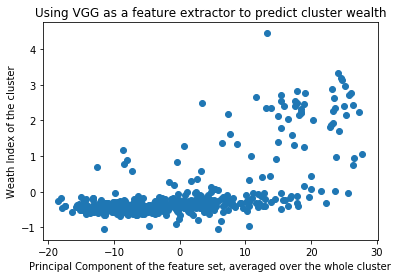

In [814]:
data_index = reduced_features.index

plt.scatter(VGG_PCA_top5[0], labels)
plt.title("Using VGG as a feature extractor to predict cluster wealth")
plt.xlabel("Principal Component of the feature set, averaged over the whole cluster")
plt.ylabel("Weath Index of the cluster")

**We notice that the first component (and actually, all components) separate rather well the cluster points for high wealth indexes, but the discrimination power in weak for wealth indexes below 5.** This means that the predicition power of our model will most likely be poor for less wealthy clusters.

We use grid search to **optimize the regularization hyperparameter parameter with 10-fold cross validation**, and find our Rˆ2 score:

In [822]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

ridge_model = Ridge(normalize = True)

alpha_range = [0.01 * i for i in range (1, 100, 5)]
param_grid = {'alpha' : alpha_range}


grid_search = GridSearchCV(ridge_model, 
                           param_grid = param_grid,
                           cv=10, # 10-fold cross validation
                           return_train_score = True)

grid_search.fit(reduced_features, cluster_wealth.wlthindf)
print('Best Hyperparameter: ', grid_search.best_params_)
print('Rˆ2 score: ', round(grid_search.score(reduced_features, cluster_wealth.wlthindf), 3))

Best Hyperparameter:  {'alpha': 0.11}
Rˆ2 score:  0.456


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


We get a Rˆ2 score of 0.456 with the daytime features extracted using the CNN.

Text(0, 0.5, 'Actual Weath Index (DHS)')

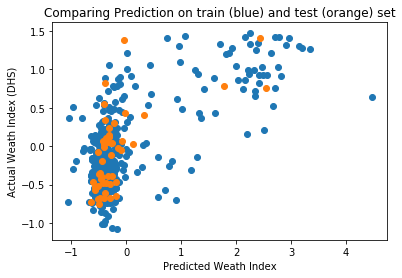

In [826]:
data_index = train
plt.scatter(labels.iloc[data_index], model.predict(features.iloc[data_index]))

data_index = test
plt.scatter(labels.iloc[data_index], model.predict(features.iloc[data_index]))

plt.title('Comparing Prediction on train (blue) and test (orange) set')
plt.xlabel('Predicted Weath Index')
plt.ylabel('Actual Weath Index (DHS)')

The two distributions are similar, which confirms that we dont overfit.

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """


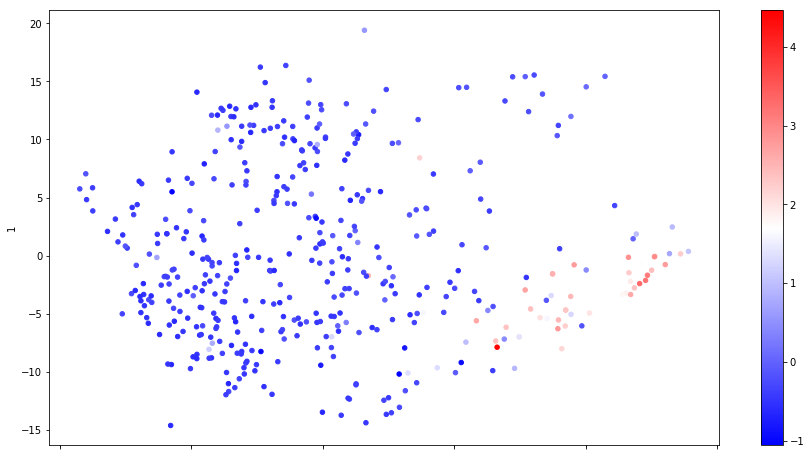

In [827]:
indexes = train

features.loc[indexes].plot.scatter(x = features.columns[0], 
                                   y = features.columns[1], 
                                   c = labels.loc[indexes],
                                   figsize=(15,8),
                                   colormap = 'bwr')


<a id='step_7'></a>

# 7. *Optional:* Replicate the transfer learning results of Jean et al (2016)

The only thing missing at this point is the "transfer learning" step. In other words, instead of using the image features extracted by the CNN directly, we want to retrain the CNN to predict nightlights from daytime imagery, and use those features, which presumably are more appropriate to our final prediction task.

## 7.1. Use the nightlights to retrain the CNN and extract features

- **INPUT**: 
 - `google_image/...`: Raw images, from Step 4
- **OUTPUT**: 
 - `google_image_features_cnn_retrained.csv`: Image features 

Following the approach used in the paper, first divide your daytime images into three groups, corresponding to images where the corresponding night-lights pixel is dim, medium, or bright. Use these values to define your groups: [0, 3), [3, 35), [35, 64). We have given you the code to do this below.

### Modify a VGG16 infrastructure into fine-tunable 3 class classifier

In [373]:
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator


base_model = VGG16(weights='imagenet', 
                   include_top=False, 
                   input_shape = (224,224,3))

# Freeze all the layers
for layer in base_model.layers:
    layer.trainable = False

Add a dense layer and a final 3-class classification layer:

In [375]:
model = models.Sequential()

model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

### Prepare the training data

Using a bash command, we place the images into 3 folders depending on the nightlight luminosity level, as described in the instructions [0, 3), [3, 35), [35, 64)
These folders are place into a parent folder called `image_triage`

To reduce the computational complexity, we reduce the images from 400 x 400 to 224 x 224 

In [378]:
data_dir = '/Users/cram/image_triage' # path to image_triage

train_datagen = ImageDataGenerator(rescale=1/224,
                                   validation_split=0.19)


# Gnerate the train and test data for the model

train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(224, 224),
        batch_size= 43,
        shuffle=True,
        class_mode='categorical',
        subset='training')


validation_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(224, 224),
        batch_size= 10,
        shuffle=True,
        class_mode='categorical',
        subset='validation')

Found 43037 images belonging to 3 classes.
Found 10093 images belonging to 3 classes.


### Train the New Model to Predict Nightlight Intensity from Daytime Images

In [382]:
rms = optimizers.RMSprop(lr=0.005, rho=0.9, epsilon=None, decay=0.0)


model.compile(optimizer=rms, loss='categorical_crossentropy')

In [383]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=1000,   #train_generator.samples/train_generator.batch_size ,
      epochs=1,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

model.save('first_attempt.h5')

Epoch 1/1
1000/1000 [==============================] - 24172s 24s/step - loss: 0.5730 - val_loss: 0.5701


The first epoch took 6h to run. We'll keep it there, but we would want to train it more if possible.

### Remove the last classification layer and use the fine-tuned model as a feature extractor

The features are stored in `correspondance_table` with the rest of the features from the default VGG

In [386]:
for i in model.layers:
    print(i.name, ' - ', i.output_shape)

vgg16  -  (None, 7, 7, 512)
flatten_5  -  (None, 25088)
dense_11  -  (None, 1024)
dropout_4  -  (None, 1024)
dense_12  -  (None, 3)


In [416]:
feature_extractor = Model(inputs=model.input, outputs=model.get_layer('dense_11').output)

In [472]:
model = feature_extractor

VGG16_transfer = pd.Series(dtype=object, index = correspondance_table.index)

from timeit import default_timer as timer
start = timer()
counter = 0
print_i = 199

for index, row in correspondance_table.iterrows():
    if index in useful_indexes:
        # if the feature is not already in the table
        if np.isnan(VGG16_transfer.loc[index]).any():
            if True: #index < 5000:
                try:
                    img_path = row.file_path    
                    img = image.load_img(img_path, target_size=(224, 224)) # original images are 400*400
                    x = image.img_to_array(img)
                    x = np.expand_dims(x, axis=0)
                    x = preprocess_input(x)
                    x_features = model.predict(x)[0]
                    VGG16_transfer.loc[index] = x_features
                    counter += 1
                except KeyboardInterrupt:
                    print("KeyboardInterrupt has been caught.")
                    break
                except:
                    pass

    # print progress
    if counter % 200 == print_i:
        print('Index: ', str(index), ', counter ', str(counter), ' - Time Elapsed: ', str(round((timer() - start) / 60, 2)), 'min') 
        print_i = print_i - 1
    # save progress
#    if counter % 500 == 0:
#        correspondance_table.to_pickle('image_features_table_transfer.pkl')
#        pass


print('Took ', str(round((timer() - start) / 60, 2)), 'min for ', counter, ' datapoints')

correspondance_table['VGG16_transfer'] = VGG16_transfer

correspondance_table.to_pickle('image_features_table_transfer.pkl')



Index:  2358 , counter  199  - Time Elapsed:  1.52 min
Index:  3440 , counter  398  - Time Elapsed:  2.98 min
Index:  4482 , counter  597  - Time Elapsed:  4.43 min
Index:  5369 , counter  796  - Time Elapsed:  5.85 min
Index:  6664 , counter  995  - Time Elapsed:  7.27 min
Index:  8147 , counter  1194  - Time Elapsed:  8.75 min
Index:  9473 , counter  1393  - Time Elapsed:  10.2 min
Index:  10244 , counter  1592  - Time Elapsed:  11.86 min
Index:  10894 , counter  1791  - Time Elapsed:  13.43 min
Index:  11526 , counter  1990  - Time Elapsed:  14.99 min
Index:  12182 , counter  2189  - Time Elapsed:  16.73 min
Index:  12830 , counter  2388  - Time Elapsed:  18.43 min
Index:  13265 , counter  2587  - Time Elapsed:  20.03 min
Index:  13675 , counter  2786  - Time Elapsed:  21.63 min
Index:  13967 , counter  2985  - Time Elapsed:  23.27 min
Index:  14352 , counter  3184  - Time Elapsed:  24.79 min
Index:  14648 , counter  3383  - Time Elapsed:  26.4 min
Index:  15016 , counter  3582  - T

## 7.2. Test whether "deep" features of satellite imagery can predict wealth
- **INPUT**: 
 - `google_image_cnn/...`: Satellite images from 7.1
- **OUTPUT**: 
 - `data/model/DHS_CNN.csv`: Merged dataset with 492 rows, and 4097 columns (one indicates average cluster wealth, 4096 CNN features)
 - R^2 of model

Repeat 6.2, except this time use the features generated from 7.1, i.e., the features that have been constructed after transfer learning. As in 6.2, show a scatterplot of the relationship between average cluster wealth (y-axis) and the first principal component of your image features. Then, report the cross-validated R^2 of your model (i.e., the average R^2 of your 10 test folds).

We average the features for each cluster, using the function defined in part 6:

In [492]:
cluster_features_transfer = cluster_wealth.apply(get_cluster_feature_vector, axis = 1)

n_sample not 100:  110 for cluster  Index(['wlthindf', 'latitude', 'longitude'], dtype='object')
n_sample not 100:  110 for cluster  Index(['wlthindf', 'latitude', 'longitude'], dtype='object')
n_sample not 100:  110 for cluster  Index(['wlthindf', 'latitude', 'longitude'], dtype='object')
n_sample not 100:  110 for cluster  Index(['wlthindf', 'latitude', 'longitude'], dtype='object')
n_sample not 100:  110 for cluster  Index(['wlthindf', 'latitude', 'longitude'], dtype='object')
n_sample not 100:  110 for cluster  Index(['wlthindf', 'latitude', 'longitude'], dtype='object')
n_sample not 100:  110 for cluster  Index(['wlthindf', 'latitude', 'longitude'], dtype='object')
n_sample not 100:  110 for cluster  Index(['wlthindf', 'latitude', 'longitude'], dtype='object')
n_sample not 100:  110 for cluster  Index(['wlthindf', 'latitude', 'longitude'], dtype='object')
n_sample not 100:  110 for cluster  Index(['wlthindf', 'latitude', 'longitude'], dtype='object')
n_sample not 100:  110 for clu

We run a PCA on those features:

In [835]:
pca_transfer = PCA(n_components=2)
pca_transfer.fit(cluster_features_transfer)

transfer_main_components = pd.DataFrame(pca_transfer.transform(cluster_features_transfer),
                                        index = cluster_features_transfer.index)


In [836]:
grid_search.fit(transfer_main_components, labels)
grid_search.score(transfer_main_components, labels)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.5424303244545097

All the variance is contained on the first 2 components, which hints that something did not go right during the training phase. The overall prediction acuracy of these 2 components is Rˆ2 of 0.54

## Combine all the features with predictive power in a single model, to generate the high-resolution map

We will use the first 2 compoments of the features extracted by the fine-tuned CNN, the first 5 components of the features from the standard VGG16 and the nightlight luminosity.

Using all these features, we get our best prediction accuracy, with an Rˆ2 of 0.77. This is just a 0.05 increase as compared to using the nighlight lminosity alone. 

In [674]:
top_features = VGG_PCA_top5
top_features = top_features.add_prefix('VGG_PCA_')
top_features['transfer_PCA_1'] = transfer_main_components[0]
top_features['transfer_PCA_2'] = transfer_main_components[1]
top_features['nightlight_med'] = cluster_nightlights.median_
top_features['nightlight_min'] = cluster_nightlights.min_
top_features['nightlight_max'] = cluster_nightlights.max_
top_features['nightlight_std'] = cluster_nightlights.std_



In [618]:
from sklearn.model_selection import GridSearchCV

ridge_model = Ridge(normalize = True)

alpha_range = [10 ** i for i in range (-2, 6)]
#alpha_range = alpha_range + [i * 5 for i in alpha_range]
#alpha_range = [50 * i for i in range(1,20)]
alpha_range.sort()

param_grid = {'alpha' : alpha_range}


grid_search = GridSearchCV(ridge_model, 
                           param_grid = param_grid,
                           cv=5, 
                           return_train_score = True)

grid_search.fit(top_features, labels)
print(grid_search.best_params_)
grid_search.score(top_features, labels)

{'alpha': 0.1}


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.7728257537878254

For part 8, we only keep the median luminosity, since other statistics dont make sens for a single image (as opposed to a cluster). We call this model `part_8_model`

In [838]:
enabled_features = [
'VGG_PCA_0',
'VGG_PCA_1',
'VGG_PCA_2',
'VGG_PCA_3',
'VGG_PCA_4',
'transfer_PCA_1',
'transfer_PCA_2',
'nightlight_med',
#'nightlight_min',
#'nightlight_max',
#'nightlight_std'
]

grid_search.fit(top_features[enabled_features], labels)
part_8_model = grid_search.best_estimator_

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# 8. Construct a high-resolution map of the  predicted wealth of Rwanda
- **INPUT**: 
 - Model, image features (data/model/features_all_predictimage_location.csv)
- **OUTPUT**: 
 - Map ('poverty_mapping.tiff')
 
Choose your favorite model from the three daytime-based models that you have trained above: 5.3 (basic daytime features), 6.2 (deep daytime features), or 7.2 (transfer-learned daytime features). Use this model to calculate the predicted wealth of every one of your original images. Create a heatmap showing the distribution of predicted wealth in Rwanda. With any luck, it will look something like this:
<img src="figure/pmap.png" alt="Map"/>

We combine all these features for each image in `correspondace_table`

In [747]:
for feature in enabled_features:
    correspondance_table[feature] = None
    

error_indexes = []
for index, row in correspondance_table.iterrows():
    if index in useful_indexes:
        try:
            vgg_features = pca_vgg.transform(row.VGG16_224_features)
        except:
            print('error at index ', index, ', reusing last image')
            error_indexes.append(index)
        transfer_features = pca_transfer.transform(row.VGG16_transfer.reshape(1, -1))
        
        new_features_list = [i for i in vgg_features[0]] + [i for i in transfer_features[0]]
        new_features_list.append(row.lightness)
        
        column_counter = 0
        for feature_name in enabled_features:
            correspondance_table[feature_name].loc[index] = new_features_list[column_counter]
            column_counter += 1


error at index  815 , reusing last image
error at index  20265 , reusing last image
error at index  20275 , reusing last image
error at index  20278 , reusing last image
error at index  20279 , reusing last image
error at index  20281 , reusing last image


In [752]:
correspondance_table[enabled_features].loc[useful_indexes]

,VGG_PCA_0,VGG_PCA_1,VGG_PCA_2,VGG_PCA_3,VGG_PCA_4,transfer_PCA_1,transfer_PCA_2,nightlight_med
379.0,-3.32645,-2.81418,11.8974,12.4218,10.1467,-774.454,-76.3782,0
380.0,-3.34352,-3.19779,12.2918,11.2058,9.95235,-752.279,-104.81,0
381.0,-2.13667,-3.46158,11.5233,10.5451,11.9186,-458.909,-25.5816,0
382.0,2.54487,-1.14957,8.20132,7.40399,13.3629,667.037,23.4443,0
383.0,-5.22504,-0.458251,7.11954,10.8527,9.35728,447.221,-27.065,0
384.0,-0.886757,6.91004,14.2296,0.0663076,1.64922,-156.086,49.2724,6
385.0,2.3179,-1.08349,18.6496,6.98078,2.54884,910.373,86.9025,7
386.0,-3.24242,-3.45257,12.8645,11.0969,7.36501,-1675.3,64.2944,9
387.0,-1.30876,-2.88227,7.96306,12.0386,11.6391,-850.923,37.3886,12
388.0,-3.13482,3.92923,-3.27966,13.7912,20.9793,567.184,-106.78,22


**We make a weath prediction, for each image:**

In [839]:
predictions = pd.Series(part_8_model.predict(correspondance_table[enabled_features].loc[useful_indexes]), 
                        index = useful_indexes)

predictions.name = 'wealth_prediction'

We notice that there are some outliers in the lower bound of the distribution, which doesnt make sens in the real life (you can't be much more poor that someone already poor). 
We therefor add a lower boud for the precision to the last 1% percentil, which corresponds to a weath index of -0.92.

In [840]:
predictions.describe(percentiles = [i / 100 for i in range(0,10) ])

count    22739.000000
mean        -0.272008
std          0.439715
min         -1.620949
0%          -1.620949
1%          -0.925973
2%          -0.846538
3%          -0.799769
4%          -0.768524
5%          -0.740927
6%          -0.718728
7.0%        -0.698342
8%          -0.681301
9%          -0.666978
50%         -0.353659
max          4.927727
Name: wealth_prediction, dtype: float64

In [791]:
predictions = predictions.clip(lower=-0.92)

We then add the predictions to the `correpondance_table`. The images that don't correpond to any cluster (are not in useful_indexes, and therefor have not have had their features computed) are assumed to have the minimal wealth index of -0.92 (most of it is in wild nature and national parks)

In [793]:
correspondance_table = pd.concat([correspondance_table.drop('wealth_prediction', axis = 1), 
                                  predictions], 
                                 axis = 1)

In [795]:
correspondance_table['wealth_prediction'] = correspondance_table.wealth_prediction.fillna(-0.92)

In [800]:
correspondance_table[['lon', 'lat', 'lightness', 'wealth_prediction']].to_csv('weath_prediction_per_image.csv')

## 9. Step back and interpret your results

Now that you are more intimately familiar with what is being done in the Jean et al. paper, provide some intelligent/critical commentary on what you think of the overall method. If you were going to set about predicting wealth from satellite imagery, is there anything you would do differently, or do you think the recipe established in the paper is as good as can be? Would you trust the maps you've generated, if you needed to use them for a research project or to make policy recommendations? What do you think the limits of this approach are?


*Replace this section with your observations and interpretation*
